<ipython-input-1-86bee3273f7c>:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv")



Training Model A...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step

Training Model B...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step

Training Model C...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step

Training Model D...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step

Model Complexity vs Performance:
     Model  Layers          Units       MAE      RMSE
0  Model A       1           [50]  0.102542  0.117597
1  Model B       1          [128]  0.119956  0.138070
2  Model C       2       [64, 32]  0.137203  0.156145
3  Model D       3  [128, 64, 32]  0.125016  0.140966


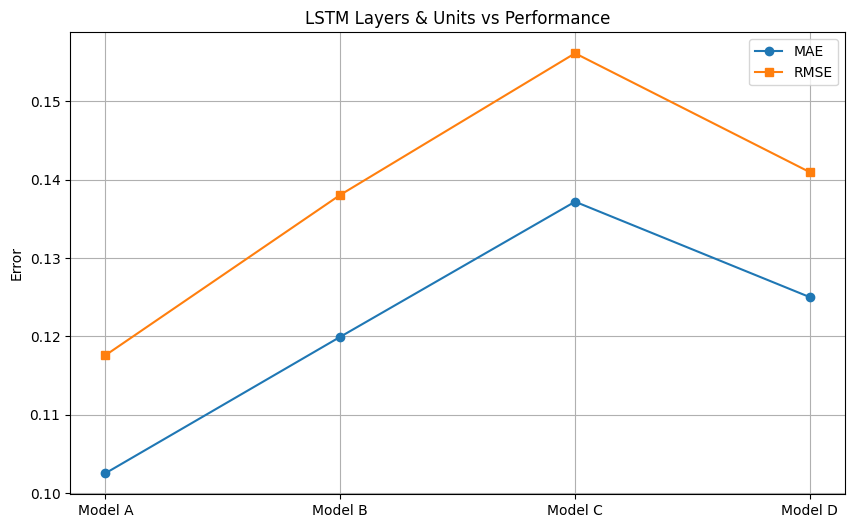

In [1]:
# LSTM Model Depth & Neuron Experiment for Time Series Forecasting (Walmart Sales Dataset)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Load and Prepare Dataset ---
# Assume CSVs already merged and cleaned
train = pd.read_csv("train.csv")
stores = pd.read_csv("stores.csv")
features = pd.read_csv("features.csv")

# Merge all
merged = train.merge(stores, on="Store").merge(features, on=["Store", "Date", "IsHoliday"])
merged["Date"] = pd.to_datetime(merged["Date"])
merged.sort_values(by=["Store", "Date"], inplace=True)

# Focus on one store & one department for simplicity
df = merged[(merged["Store"] == 1) & (merged["Dept"] == 1)]

# Select features
df = df[["Date", "Weekly_Sales"]].copy()
df.set_index("Date", inplace=True)

# Normalize sales
scaler = MinMaxScaler()
df["Weekly_Sales"] = scaler.fit_transform(df[["Weekly_Sales"]])

# --- Prepare Sequences ---
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 14
X, y = create_sequences(df["Weekly_Sales"].values, seq_len)

# Reshape for LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split train-test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Model Factory ---
def build_lstm_model(num_layers, units_list, dropout_rate):
    model = Sequential()
    for i in range(num_layers):
        return_seq = i < (num_layers - 1)
        model.add(LSTM(units_list[i], return_sequences=return_seq, input_shape=(seq_len, 1)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

# --- Experiment Configurations ---
configs = [
    {"name": "Model A", "layers": 1, "units": [50], "dropout": 0.2},
    {"name": "Model B", "layers": 1, "units": [128], "dropout": 0.2},
    {"name": "Model C", "layers": 2, "units": [64, 32], "dropout": 0.2},
    {"name": "Model D", "layers": 3, "units": [128, 64, 32], "dropout": 0.3},
]

results = []

# --- Run Experiments ---
for cfg in configs:
    print(f"\nTraining {cfg['name']}...")
    model = build_lstm_model(cfg["layers"], cfg["units"], cfg["dropout"])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0, callbacks=[early_stop])

    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results.append({"Model": cfg["name"], "Layers": cfg["layers"], "Units": cfg["units"], "MAE": mae, "RMSE": rmse})

# --- Results Summary ---
results_df = pd.DataFrame(results)
print("\nModel Complexity vs Performance:")
print(results_df)

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(results_df["Model"], results_df["MAE"], marker='o', label="MAE")
plt.plot(results_df["Model"], results_df["RMSE"], marker='s', label="RMSE")
plt.title("LSTM Layers & Units vs Performance")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/5


<ipython-input-5-08c948d7b36e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Weekly_Sales'] = scaler.fit_transform(filtered_data[['Weekly_Sales']])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0085 - val_loss: 0.0011
Epoch 2/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0040 - val_loss: 9.3227e-04
Epoch 3/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0038 - val_loss: 8.1324e-04
Epoch 4/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0031 - val_loss: 6.9839e-04
Epoch 5/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0026 - val_loss: 6.6943e-04
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


368/368 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0083 - val_loss: 0.0012
Epoch 2/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0038 - val_loss: 8.2768e-04
Epoch 3/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0033 - val_loss: 7.4000e-04
Epoch 4/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0028 - val_loss: 6.5535e-04
Epoch 5/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0029 - val_loss: 6.9110e-04
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0070 - val_loss: 0.0011
Epoch 2/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0036 - val_loss: 6.9235e-04
Epoch 3/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0030 - val_loss: 7.0557e-04
Epoch 4/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0028 - val_loss: 6.5998e-04
Epoch 5/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0026 - val_loss: 6.3627e-04
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0080 - val_loss: 0.0012
Epoch 2/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0047 - val_loss: 9.5147e-04
Epoch 3/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0036 - val_loss: 7.5190e-04
Epoch 4/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0029 - val_loss: 6.6314e-04
Epoch 5/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0032 - val_loss: 6.5366e-04
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


368/368 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 0.0075 - val_loss: 0.0011
Epoch 2/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.0040 - val_loss: 8.2774e-04
Epoch 3/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 0.0033 - val_loss: 6.5408e-04
Epoch 4/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 0.0031 - val_loss: 7.0147e-04
Epoch 5/5
368/368 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - loss: 0.0029 - val_loss: 6.7013e-04
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


349/349 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0091 - val_loss: 0.0011
Epoch 2/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0043 - val_loss: 9.6190e-04
Epoch 3/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0034 - val_loss: 8.7823e-04
Epoch 4/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0031 - val_loss: 8.9610e-04
Epoch 5/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0029 - val_loss: 7.6252e-04
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


349/349 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0071 - val_loss: 0.0010
Epoch 2/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0038 - val_loss: 9.1662e-04
Epoch 3/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0030 - val_loss: 8.0742e-04
Epoch 4/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0029 - val_loss: 6.6398e-04
Epoch 5/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0025 - val_loss: 6.5486e-04
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


349/349 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 0.0065 - val_loss: 0.0011
Epoch 2/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.0036 - val_loss: 7.2536e-04
Epoch 3/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 0.0029 - val_loss: 6.6223e-04
Epoch 4/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0027 - val_loss: 6.2052e-04
Epoch 5/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0025 - val_loss: 6.2885e-04
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


349/349 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0084 - val_loss: 0.0012
Epoch 2/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.0042 - val_loss: 9.4297e-04
Epoch 3/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.0036 - val_loss: 9.0593e-04
Epoch 4/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.0032 - val_loss: 6.7741e-04
Epoch 5/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0028 - val_loss: 7.2252e-04
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


349/349 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - loss: 0.0072 - val_loss: 0.0011
Epoch 2/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - loss: 0.0042 - val_loss: 8.3658e-04
Epoch 3/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - loss: 0.0032 - val_loss: 7.2279e-04
Epoch 4/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - loss: 0.0030 - val_loss: 6.2920e-04
Epoch 5/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - loss: 0.0028 - val_loss: 7.0457e-04
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0093 - val_loss: 0.0011
Epoch 2/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0041 - val_loss: 0.0010
Epoch 3/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0035 - val_loss: 8.3696e-04
Epoch 4/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0032 - val_loss: 7.8274e-04
Epoch 5/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0033 - val_loss: 7.3195e-04
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0064 - val_loss: 9.8864e-04
Epoch 2/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0034 - val_loss: 7.8277e-04
Epoch 3/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0029 - val_loss: 7.9953e-04
Epoch 4/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0027 - val_loss: 7.5634e-04
Epoch 5/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0029 - val_loss: 7.3792e-04
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


306/306 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - loss: 0.0078 - val_loss: 0.0011
Epoch 2/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - loss: 0.0040 - val_loss: 9.7392e-04
Epoch 3/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 0.0031 - val_loss: 7.8358e-04
Epoch 4/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - loss: 0.0028 - val_loss: 7.2694e-04
Epoch 5/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 0.0026 - val_loss: 9.4687e-04
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


306/306 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - loss: 0.0074 - val_loss: 0.0013
Epoch 2/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - loss: 0.0044 - val_loss: 0.0010
Epoch 3/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - loss: 0.0038 - val_loss: 8.8897e-04
Epoch 4/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - loss: 0.0032 - val_loss: 7.3657e-04
Epoch 5/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - loss: 0.0030 - val_loss: 6.4013e-04
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


306/306 ━━━━━━━━━━━━━━━━━━━━ 35s 103ms/step - loss: 0.0067 - val_loss: 0.0011
Epoch 2/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 100ms/step - loss: 0.0043 - val_loss: 8.4621e-04
Epoch 3/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - loss: 0.0034 - val_loss: 8.1737e-04
Epoch 4/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - loss: 0.0031 - val_loss: 7.2959e-04
Epoch 5/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - loss: 0.0030 - val_loss: 6.6238e-04
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step
    Seq_Len  Layers  Units  Dropout       MAE      RMSE
0         7       1     50      0.2  0.014890  0.030528
1         7       1    100      0.2  0.013968  0.030360
2         7       2    100      0.2  0.015054  0.030037
3         7       2    100      0.4  0.015103  0.030309
4         7       2    128      0.4  0.014120  0.030460
5        14       1     50      0.2  0.019226  0.031943
6        14       1    100      0.2  0.014078  0.030113
7        14       2    100      0.2  0.013350  0.029521
8        1

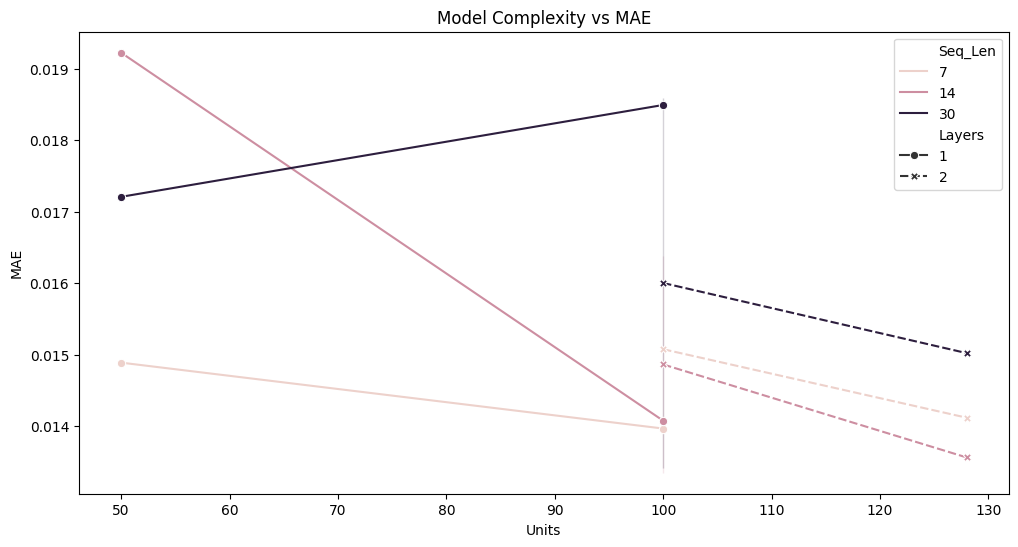

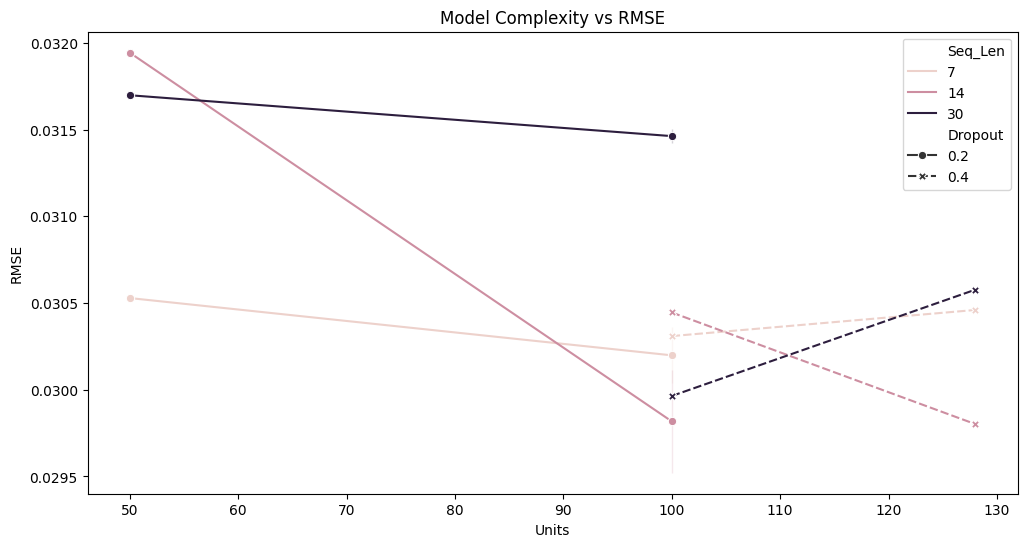

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import os

# ----------------------
# Load and Preprocess Data
# ----------------------

train_df = pd.read_csv("train.csv")
stores_df = pd.read_csv("stores.csv")
features_df = pd.read_csv("features.csv")

# Merge datasets
data = train_df.merge(stores_df, on="Store").merge(features_df, on=["Store", "Date", "IsHoliday"])

# Convert date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(['Store', 'Dept', 'Date'])

# Filter one department or multiple
# For simplicity, let's experiment on a few departments across multiple stores
filtered_data = data[(data['Dept'].isin([1, 2, 3]))]

# ----------------------
# Normalize Data
# ----------------------
scaler = MinMaxScaler()
filtered_data['Weekly_Sales'] = scaler.fit_transform(filtered_data[['Weekly_Sales']])

# ----------------------
# Create Sequences for Modeling
# ----------------------
def create_sequences(df, seq_length=14):
    X, y = [], []
    for store_dept in df.groupby(['Store', 'Dept']):
        group = store_dept[1].sort_values('Date')
        sales = group['Weekly_Sales'].values
        for i in range(len(sales) - seq_length):
            X.append(sales[i:i+seq_length])
            y.append(sales[i+seq_length])
    return np.array(X), np.array(y)

# ----------------------
# Experiment Setup
# ----------------------
sequence_lengths = [7, 14, 30]
layer_configs = [
    (1, 50, 0.2),
    (1, 100, 0.2),
    (2, 100, 0.2),
    (2, 100, 0.4),
    (2, 128, 0.4)
]

results = []

# ----------------------
# Training Loop
# ----------------------
for seq_len in sequence_lengths:
    X, y = create_sequences(filtered_data, seq_len)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Train/Test Split
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    for layers, units, dropout in layer_configs:
        model = Sequential()
        for l in range(layers - 1):
            model.add(LSTM(units, return_sequences=True, input_shape=(seq_len, 1)))
            model.add(Dropout(dropout))
        model.add(LSTM(units, input_shape=(seq_len, 1)))
        model.add(Dropout(dropout))
        model.add(Dense(1))

        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

        es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=32, callbacks=[es], verbose=1)

        y_pred = model.predict(X_test).flatten()
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        results.append({
            'Seq_Len': seq_len,
            'Layers': layers,
            'Units': units,
            'Dropout': dropout,
            'MAE': mae,
            'RMSE': rmse
        })

# ----------------------
# Results DataFrame & Plot
# ----------------------
results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="Units", y="MAE", hue="Seq_Len", style="Layers", markers=True)
plt.title("Model Complexity vs MAE")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="Units", y="RMSE", hue="Seq_Len", style="Dropout", markers=True)
plt.title("Model Complexity vs RMSE")
plt.show()